# 3. Test

In [1]:
import sys, os
import pandas as pd
sys.path.append("../../../../")

from Clust.setting import influx_setting_KETI as ins
from Clust.clust.ingestion.influx import influx_client_v2 as influx_Client
from Clust.clust.ingestion.mongo.mongo_client import MongoClient
db_client = influx_Client.InfluxClient(ins.CLUSTDataServer2)
mongo_client = MongoClient(ins.CLUSTMetaInfo2)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cuda is available.


In [2]:
from Clust.clust.ML.common import train_pipeline

## 1. Data Preparation

In [3]:
app_name= "Hs2SwineFarmWithWeatherTime" # "Hs2SwineFarmWithWeatherTime", "energy"
model_method = 'GRU_rg'
model_clean = True
step = 'test'
bucket_name = 'integration'
data_clean_level=0

In [4]:
model_name = None
model_name = train_pipeline.get_default_model_name(model_name, app_name, model_method, model_clean)
collection_name = 'meta'
db_name = 'model'
model_meta= mongo_client.get_document_by_json(db_name, collection_name, {'modelName': model_name})[4] ## ??

In [5]:
model_meta

{'trainDataInfo': {'data_name': 'regression_energy_cleanLevel0_trainX',
  'ingestion_param': {'start_time': '2016-01-11',
   'end_time': '2016-04-15',
   'ms_list_info': [['life_indoor_environment', 'humidityTrain_10min'],
    ['life_indoor_environment', 'temperatureTrain_10min'],
    ['weather_outdoor_environment', 'belgiumChieverseAirportTrain_10min']]},
  'integration_param': {'param': {},
   'method': 'meta',
   'integration_duration': 'common',
   'integration_frequency': 600},
  'clean_level': 0,
  'process_param': {'refine_param': {'removeDuplication': {'flag': False},
    'staticFrequency': {'flag': False, 'frequency': None}},
   'outlier_param': {'certainErrorToNaN': {'flag': False},
    'unCertainErrorToNaN': {'flag': False}},
   'imputation_param': {'flag': False}}},
 'modelName': 'energy_GRU_rg_True',
 'dataSplitMode': 'window_split',
 'featureXList': ['Press_mm_hg',
  'RH_1',
  'RH_2',
  'RH_3',
  'RH_4',
  'RH_5',
  'RH_6',
  'RH_7',
  'RH_8',
  'RH_9',
  'RH_out',
  'T1'

### 1-2. Data Ingestion
#### 1-2-1. X-y Data Ingestion pipeline

In [6]:
model_purpose = model_meta['modelPurpose']
dataset_name = model_purpose + '_' + app_name  
scaler_param= model_meta['scalerParam']
data_name_X = dataset_name + '_cleanLevel' + str(data_clean_level)+'_'+step+'X'
data_name_y = dataset_name+'_cleanLevel' + str(data_clean_level)+'_'+ step+'y'
data_y_flag = model_meta['data_y_flag']

In [7]:
feature_X_list = model_meta['featureXList']
feature_y_list = model_meta["featureyList"]
model_file_path = model_meta['files']['modelFile']["filePath"]

In [8]:
# Data Ingestion
ingestion_method = 'ms_all'
ingestion_param_X = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_X,
    'feature_list' : feature_X_list                              
}
ingestion_param_y = {
    "bucket_name" : bucket_name,
    'ms_name' : data_name_y,
    'feature_list' : feature_y_list                              
}

In [9]:
data_X, data_y = train_pipeline.get_Xy_data_in_Clust(ingestion_param_X, data_y_flag, ingestion_param_y, ingestion_method, db_client)

#### 1-2-2. Random Nan Insert (Test)
#### 1-2-3. Data scaling

In [10]:
X_scaler_file_path = model_meta['files']['XScalerFile']["filePath"]
y_scaler_file_path = model_meta['files']['yScalerFile']["filePath"]
y_scaler_file_path

'./scaler/regression_energy_cleanLevel0_trainy/minmax/f69156750a210491ffd4a67b605bc88b/scaler.pkl'

In [11]:
scaler_param = model_meta["scalerParam"]
from Clust.clust.ML.tool import scaler as ml_scaler
test_X, scaler_X = ml_scaler.get_scaled_test_data(data_X, X_scaler_file_path, scaler_param)
test_y, scaler_y = ml_scaler.get_scaled_test_data(data_y, y_scaler_file_path, scaler_param)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


#### 1-2-2. Random Nan Insert (Test)
#### 1-2-3. Data scaling

In [12]:
split_mode = model_meta['dataSplitMode']
transformParameter = model_meta["transformParameter"]
test_X_array, test_y_array = train_pipeline.get_transfomed_data(split_mode, transformParameter, test_X, test_y)

window_size: 144 nan_limit_num: 72
(6048, 24) (42, 144, 24)
(42, 1) (42, 1)


In [13]:
modelParameter = model_meta["modelParameter"]

testParameter = {
    'device': 'cpu',
    'batch_size': model_meta["trainParameter"]['batch_size']
}

In [14]:
#3. Test model
from Clust.clust.ML.regression_YK.test import RegressionTest as RT

rt = RT()
rt.set_param(testParameter)
rt.set_model(model_method, model_file_path, modelParameter)
rt.set_data(test_X_array, test_y_array)
preds, trues = rt.test()

features shape: torch.Size([42, 144, 24]) targets shape:  torch.Size([42, 1])

Start testing data



In [15]:
print(test_X_array.shape, test_y_array.shape)
print(preds.shape, trues.shape)

(42, 144, 24) (42, 1)
(32,) (32,)


In [16]:
data_y_flag

True

scale
        value  prediction
0   17.370001   10.157236
1   20.650000    9.745333
2   11.420000    9.230944
3   10.680000    9.874599
4   12.439999    9.917680
5   11.170000    9.465993
6   24.120001   10.033264
7   10.990000   10.410044
8   13.760000    9.533790
9   14.560000    9.742868
10  14.970000    9.693753
11  13.429999    9.860579
12  11.570000    9.965724
13   9.330000   10.754500
14  15.580000   10.179406
15  20.929998    9.889416
16  11.990000    9.520499
17  15.370000   10.190338
18  10.470000    9.860127
19  14.410000    9.974400
20  10.160000    9.668745
21  15.120000    9.614093
22  12.320000    9.933445
23  10.460000    9.315143
24  15.060000    8.859575
25   9.680000    9.296025
26  10.690000   10.309089
27  17.799997   10.209410
28  10.690000   10.175481
29  17.059998    9.832749
30  20.879999   10.052874
31  10.890000    9.732653
{'mae': 4.183413, 'rmse': 5.5330790281265765, 'r2': -1.1900435076702656, 'mape': 25.809186697006226}


<Axes: >

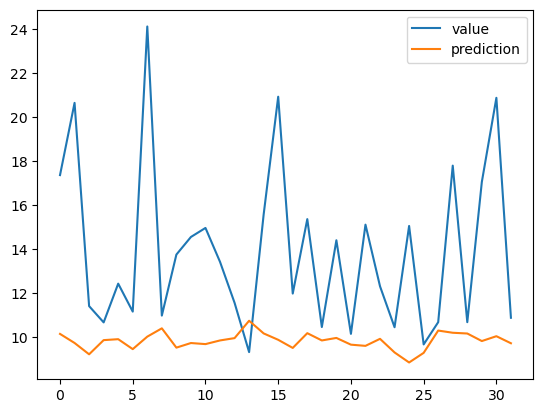

In [19]:
from Clust.clust.tool.stats_table import metrics
if data_y_flag:
    scaler = scaler_y
    feature_list = feature_y_list
    target = feature_y_list[0]
else:
    scaler = scaler_X
    feature_list = feature_X_list
    target = feature_y_list[0]
    
from Clust.clust.ML.tool import data as ml_data 
df_result = ml_data.get_prediction_df_result(preds, trues, scaler_param, scaler, feature_list, target)
result_metrics =  metrics.calculate_metrics_df(df_result)
print(df_result)
print(result_metrics)
df_result.plot()

In [18]:
# 5. Only For IPython Notebook
from Clust.clust.tool.plot.plot_two_data import plot_predictions
import plotly.offline as pyo
# Set notebook mode to work in offline
pyo.init_notebook_mode()
plot_predictions(df_result)

ModuleNotFoundError: No module named 'chart_studio'